# The Effectiveness of Generative Models for Data Augmentation in Medical Applications

The objective of this project is to explore and compare multiple solutions for the problem of data augmentation in the medical domain. In this work we focus on data augmentation using generative models and experiment with autoencoders, variational autoencoders and generative adversarial networks.


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from PIL import Image

# Import of the MedMNIST Data

The experiments of this project are made on 8 of the 10 open medical data sets of the MedMNIST decathlon collection. The MedMNIST data is standardized and pre-processed into the same format and same small size of 28 × 28 pixels, covers diverse tasks, and is split in training-validation- test subsets. 

To reflect the size of data sets available in medical imaging community, we artificially restrict our access to data to small subsets of the MedMNIST data sets. We select random subsets of our original data sets in order to keep approximately 150 images per class, and preserve a train-validation ratio of 9:1. We then generate 150 additional images per label. The underlying idea is that the constraint of small data sets should allow to highlight the effectiveness of the various tested augmentation methods.

In [3]:
def getData(name):
  names = ['breastmnist','dermamnist', 'octmnist', 'pathmnist', 'pneumoniamnist', 'organmnist_axial',
           'organmnist_coronal', 'organmnist_sagittal']
  if name not in names:
    print('Please enter a valid dataset name!')
  
  else:
    path = '/content/drive/MyDrive/medmnist/' + name + '.npz'
    
    with np.load(path) as data:
      train_images = data['train_images.npy']
      train_labels = data['train_labels.npy']
      val_images = data['val_images.npy']
      val_labels = data['val_labels.npy']
      test_images = data['test_images.npy']
      test_labels = data['test_labels.npy']
  
    if name == 'pathmnist' or name =='dermamnist':
      in_channels = 3
    else:
      in_channels = 1

    num_classes = len(np.unique(train_labels))

    if name == 'pneumoniamnist' or name == 'breastmnist':
      task = 'binary-class'
    else: 
      task = 'multi-class'

    #Subsets
    if name != 'breastmnist':
      full_n_train = train_images.shape[0]
      subset_n_train = num_classes * 150
      idx_train = np.random.randint(full_n_train, size=subset_n_train)
      train_images = train_images[idx_train,:]
      train_labels = train_labels[idx_train,:]

      full_n_val = val_images.shape[0]
      subset_n_val = np.int(np.round(subset_n_train / 9))
      idx_val = np.random.randint(full_n_val, size=subset_n_val)
      val_images = val_images[idx_val,:]
      val_labels = val_labels[idx_val,:]

    if name == 'organmnist_axial':
      full_n_test = test_images.shape[0]
      subset_n_test = np.int(np.round(full_n_test/2))
      idx_test = np.random.randint(full_n_test, size=subset_n_test)
      test_images = test_images[idx_test,:]
      test_labels = test_labels[idx_test,:]

  return train_images, train_labels, val_images, val_labels, test_images, test_labels, in_channels, num_classes, task

As the data sets are not extremely unbalanced, the subsets are actually generated by uniformly sampling at random $n * 150$ observations in each set, where $n$ is the number of classes. 


In [4]:
train_images, train_labels, val_images, val_labels, test_images, test_labels, in_channels, num_classes, task = getData('pneumoniamnist')

### Datasets and DataLoaders

Before we go on with our experiment and models, we need to define the PyTorch Datasets and DataLoader to feed our models.



In [5]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)


In [6]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0], std=[1])])

train_data = MyDataset(train_images, train_labels, transform=transform)
val_data = MyDataset(val_images, val_labels, transform=transform)
test_data = MyDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Baseline Classification 

To evaluate the utility and efficiency of generative models as a data augmentation tool we set up a simple experiment. We compare the performances of a vanilla image classifier on the original data sets we have with the data sets augmented by several different generative models in turn. 

### ResNet Model

We implement A ResNet-18 with a simple early-stopping strategy on validation set as a classification method. In this model, the input channel is `1` for grey- scale data sets, and `3` for triple-channel data sets. The input resolution is `28`. The model is trained for `100` epochs, using a `Cross Entropy Loss` and a `SGD optimizer` with a batch size of `128` and an initial learning rate of `1e−3`. 

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [9]:
def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)

### Evaluation Metrics

Area under ROC curve (AUC) and Accuracy (ACC) are used for the evaluation of the classifier performance on each data set. AUC is a threshold-free metric to evaluate continuous prediction scores, and ACC is the ratio of
number of correct predictions to the total number of input samples. While ACC works well if there are equal number of samples belonging to each class, AUC is less sensitive to class imbalance.


In [10]:
def getAUC(y_true, y_score, task):
    if task == 'binary-class':
        y_score = y_score[:,-1]
        return roc_auc_score(y_true, y_score)
    else:
        auc = 0
        zero = np.zeros_like(y_true)
        one = np.ones_like(y_true)
        for i in range(y_score.shape[1]):
            y_true_binary = np.where(y_true == i, one, zero)
            y_score_binary = y_score[:, i]
            auc += roc_auc_score(y_true_binary, y_score_binary)
        return auc / y_score.shape[1]

In [11]:
def getACC(y_true, y_score, task, threshold=0.5):
    if task == 'binary-class':
      y_pre = np.zeros_like(y_true)
      for i in range(y_score.shape[0]):
        y_pre[i] = (y_score[i][-1] > threshold)
      return accuracy_score(y_true, y_pre)
    else:
        y_pre = np.zeros_like(y_true)
        for i in range(y_score.shape[0]):
            y_pre[i] = np.argmax(y_score[i])
        return accuracy_score(y_true, y_pre)

### Training, Validation and Test

In [12]:
def train(model, optimizer, criterion, train_loader, device, task):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))

        targets = targets.squeeze().long().to(device)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

In [13]:
def val(model, val_loader, device, val_auc_list, val_acc_list, state_list, task, dir_path, epoch):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            outputs = model(inputs.to(device))

            targets = targets.squeeze().long().to(device)
            m = nn.Softmax(dim=1)
            outputs = m(outputs).to(device)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
        val_auc_list.append(auc)
        val_acc_list.append(acc)
        if epoch % 10 == 0:
          print('Validation AUC: %.5f ACC: %.5f' % (auc, acc))

    state = {
        'net': model.state_dict(),
        'auc': auc,
        'epoch': epoch,
    }

    state_list.append(state)


In [14]:
def test(model, data_loader, device, task):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            outputs = model(inputs.to(device))

            targets = targets.squeeze().long().to(device)
            m = nn.Softmax(dim=1)
            outputs = m(outputs).to(device)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()
        auc = getAUC(y_true, y_score, task)
        acc = getACC(y_true, y_score, task)
        print('Test AUC: %.5f ACC: %.5f' % (auc, acc))

In [16]:
start_epoch = 0
end_epoch = 100
lr = 0.001
val_auc_list = []
val_acc_list = []
state_list = []
dir_path = '/content/drive/MyDrive/'
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet18(in_channels, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

for epoch in trange(start_epoch, end_epoch):
  train(model, optimizer, criterion, train_loader, device, task)
  val(model, val_loader, device, val_auc_list, val_acc_list, state_list, task, dir_path, epoch)

acc_list = np.array(val_acc_list)
index = acc_list.argmax()

path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, acc_list[index]))
torch.save(state_list[index], path)

print('epoch %s is the best model' % (index))

  1%|          | 1/100 [00:00<00:33,  2.98it/s]

Validation AUC: 0.61304 ACC: 0.30303


 11%|█         | 11/100 [00:02<00:23,  3.79it/s]

Validation AUC: 0.93478 ACC: 0.69697


 21%|██        | 21/100 [00:05<00:20,  3.83it/s]

Validation AUC: 0.96957 ACC: 0.90909


 31%|███       | 31/100 [00:08<00:18,  3.81it/s]

Validation AUC: 0.96522 ACC: 0.87879


 41%|████      | 41/100 [00:10<00:15,  3.82it/s]

Validation AUC: 0.97391 ACC: 0.87879


 51%|█████     | 51/100 [00:13<00:12,  3.82it/s]

Validation AUC: 0.96957 ACC: 0.90909


 61%|██████    | 61/100 [00:16<00:10,  3.78it/s]

Validation AUC: 0.96957 ACC: 0.90909


 71%|███████   | 71/100 [00:18<00:07,  3.80it/s]

Validation AUC: 0.97391 ACC: 0.87879


 81%|████████  | 81/100 [00:21<00:05,  3.79it/s]

Validation AUC: 0.96957 ACC: 0.90909


 91%|█████████ | 91/100 [00:23<00:02,  3.80it/s]

Validation AUC: 0.96957 ACC: 0.90909


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]

epoch 20 is the best model


In [17]:
restore_model_path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, acc_list[index]))
model.load_state_dict(torch.load(restore_model_path)['net'])
test(model, test_loader, device, task)

Test AUC: 0.92209 ACC: 0.81090


# Augmentation using AEs

### Deep AE Model

Autoencoders are a type of neural networks used to learn a representation for a set of data. The aim of an autoencoder is to find the function mapping an input $x$ to itself. This objective is known as reconstruction, and an autoencoder accomplishes this through the following process: first an encoder learns the data representation $z$ from the input features $x$ in lower-dimension space by extracting the most relevant features of the data.

To optimize our autoencoder to reconstruct data, we minimize the what is called the reconstruction loss. The reconstruction loss is this case is actually the `Mean-Squared Error` loss. We implement a simple autoencoder with `4` hidden fully connected layers for both its encoder and decoder components. The model is trained for `300` epochs, using an `Adam optimizer` with a batch size of `128` and an initial learning rate of `1e−3`.

In [18]:
class AE(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        # encoder
        self.enc1 = nn.Linear(in_features=in_channels*784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=in_channels*784)
   
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        encoded = torch.sigmoid(self.enc5(x))
        x = F.relu(self.dec1(encoded))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstructed = torch.sigmoid(self.dec5(x))
        return reconstructed

### Train and Validation

In [19]:
def train_ae(model, dataloader, optimizer, criterion, device, epoch):
    train_loss = 0.0
    for img, _  in dataloader:
      img = img.view(-1, in_channels * 784).to(device)
      optimizer.zero_grad()

      outputs = model(img)
      loss = criterion(outputs, img)

      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss = train_loss/len(dataloader.dataset)

    if epoch % 50 == 0:
      print('\nAE Train Loss: {:.4f}'.format(train_loss))

In [20]:
def val_ae(model, dataloader, criterion, device, epoch, loss_list):
    val_loss = 0.0
    with torch.no_grad():
      for img, _ in dataloader:
        img = img.view(-1, in_channels * 784).to(device)
        
        outputs = model(img)
        loss = criterion(outputs, img)
        val_loss += loss.item()

    loss_list.append(val_loss/len(dataloader.dataset))

    if epoch % 50 == 0:
      print('AE Val Loss: {:.4f}'.format(val_loss/len(dataloader.dataset)))

In [21]:
loss_list = []
start_epoch = 0
end_epoch= 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae=AE(in_channels).to(device)

optimizer_ae = optim.Adam(ae.parameters(), lr=1e-3)
ae_loss = nn.MSELoss()

for epoch in trange(start_epoch, end_epoch):
  train_ae(ae, train_loader, optimizer_ae, ae_loss, device, epoch)
  val_ae(ae, val_loader, ae_loss, device, epoch, loss_list)

  1%|          | 2/300 [00:00<00:24, 12.10it/s]


AE Train Loss: 0.0003
AE Val Loss: 0.0010


 17%|█▋        | 52/300 [00:03<00:18, 13.77it/s]


AE Train Loss: 0.0002
AE Val Loss: 0.0005


 34%|███▍      | 102/300 [00:07<00:14, 13.97it/s]


AE Train Loss: 0.0001
AE Val Loss: 0.0003


 51%|█████     | 152/300 [00:10<00:10, 13.76it/s]


AE Train Loss: 0.0001
AE Val Loss: 0.0003


 67%|██████▋   | 202/300 [00:14<00:06, 14.46it/s]


AE Train Loss: 0.0001
AE Val Loss: 0.0003


 84%|████████▍ | 252/300 [00:17<00:03, 14.49it/s]


AE Train Loss: 0.0001
AE Val Loss: 0.0003


100%|██████████| 300/300 [00:21<00:00, 14.10it/s]


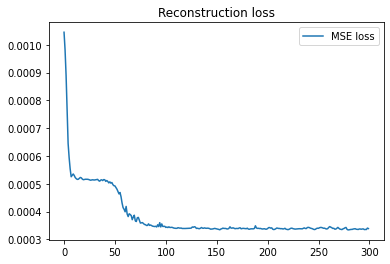

In [22]:
plt.plot(loss_list, label = 'MSE loss')
plt.title('Reconstruction loss')
plt.xlabel='epochs'
plt.legend()
plt.show()

### Augmentation and Evaluation

In [23]:
reconstructions = []
labs = []

with torch.no_grad():
    for batch_features, labels in train_loader:
        test_examples = batch_features.view(-1, in_channels * 784).to(device)
        
        reconstructions.append(ae(test_examples))
        labs.append(labels)

reconstructions = reconstructions * 255

In [24]:
aug_images = reconstructions[0].view(128, in_channels, 28, 28).to("cpu").numpy()
aug_labels = labs[0].to("cpu").numpy()

for i in range(num_classes-1):
  aug_images = np.concatenate((aug_images, reconstructions[i+1].view(128, in_channels, 28, 28).to("cpu").numpy()))
  aug_labels = np.concatenate((aug_labels,labs[i+1].to("cpu").numpy()))

if in_channels == 1:
  aug_images = aug_images.squeeze(1)
if in_channels == 3:
  aug_images = aug_images.transpose(0,2,3,1)

In [25]:
ae_aug_train_images = np.concatenate((train_images, aug_images))
ae_aug_train_labels = np.concatenate((train_labels, aug_labels))

ae_aug_train_data = MyDataset(ae_aug_train_images, ae_aug_train_labels, transform=transform)
ae_aug_train_loader = DataLoader(ae_aug_train_data, batch_size=batch_size, shuffle=True)

In [26]:
end_epoch = 100
val_auc_list = []; val_acc_list = []; state_list = []
dir_path = '/content/drive/MyDrive/'

for epoch in trange(start_epoch, end_epoch):
  train(model, optimizer, criterion, ae_aug_train_loader, device, task)
  val(model, val_loader, device, val_auc_list, val_acc_list, state_list, task, dir_path, epoch)

acc_list = np.array(val_acc_list)
index = acc_list.argmax()

path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, acc_list[index]))
torch.save(state_list[index], path)

print('epoch %s is the best model' % (index))

  1%|          | 1/100 [00:00<00:51,  1.92it/s]

Validation AUC: 0.93913 ACC: 0.72727


 11%|█         | 11/100 [00:05<00:40,  2.21it/s]

Validation AUC: 0.97826 ACC: 0.93939


 21%|██        | 21/100 [00:09<00:35,  2.22it/s]

Validation AUC: 0.97826 ACC: 0.93939


 31%|███       | 31/100 [00:14<00:31,  2.20it/s]

Validation AUC: 0.99130 ACC: 0.87879


 41%|████      | 41/100 [00:18<00:26,  2.20it/s]

Validation AUC: 0.97826 ACC: 0.93939


 51%|█████     | 51/100 [00:23<00:22,  2.19it/s]

Validation AUC: 0.97826 ACC: 0.93939


 61%|██████    | 61/100 [00:27<00:17,  2.18it/s]

Validation AUC: 0.98696 ACC: 0.93939


 71%|███████   | 71/100 [00:32<00:13,  2.18it/s]

Validation AUC: 0.97826 ACC: 0.90909


 81%|████████  | 81/100 [00:36<00:08,  2.17it/s]

Validation AUC: 0.98696 ACC: 0.93939


 91%|█████████ | 91/100 [00:41<00:04,  2.16it/s]

Validation AUC: 0.97826 ACC: 0.93939


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]

epoch 87 is the best model


In [27]:
restore_model_path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, acc_list[index]))
model.load_state_dict(torch.load(restore_model_path)['net'])
test(model, test_loader, device, task)

Test AUC: 0.91671 ACC: 0.80449


### Visualization

In [28]:
samples = reconstructions[0][:64,].view(64,in_channels, 28, 28)
img_list=[]
img_list.append(vutils.make_grid(samples.cpu(), padding=2, normalize=True))

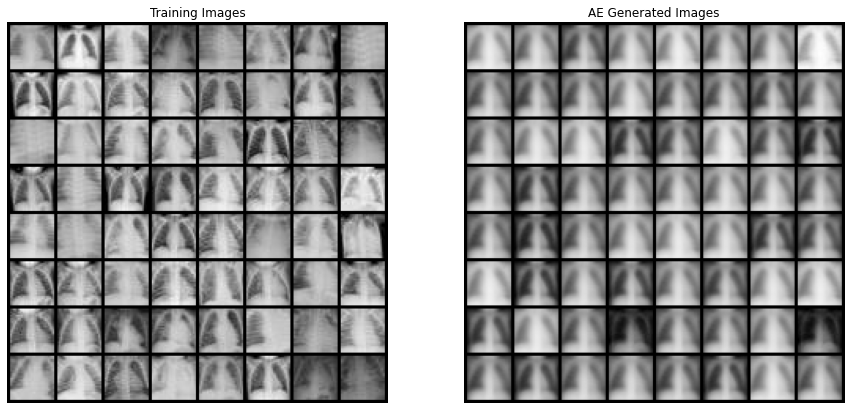

In [29]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the generated images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("AE Generated Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Augmentation using VAEs

### cVAE Model

VAEs aim to model the underlying probability distribution of a data set so that it could sample new data from that distribution. The structure of a VAE is similar to the structure of an autoencoder. That is, the VAE is composed of an encoder net $q(z|x)$ for $z$ the encoded representation of the data, and a decoder net $p(x|z)$. 

In the case of data augmentation, it can be useful to have corresponding labels for new generated data, and therefore we direct our choice towards a conditional version of a VAE. cVAEs were introduced to model latent variables and data, both conditioned to some random variables. While vanilla VAEs allow no control over the data generation process, the cVAEs can be used to generate specific data. 

We implement a simple cVAE with `2` hidden fully connected layers for both its encoder and decoder components. The model is trained for `300` epochs, using an `Adam optimizer` with a batch size of `128`.

In [31]:
class cVAE(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(cVAE, self).__init__()

        self.in_channels = in_channels

        self.enc1 = nn.Linear(in_channels* 784 + n_classes, 512) #512: hidden units
        self.enc2 = nn.Linear(512, 256) #256: hidden units
        self.enc31 = nn.Linear(256, 2) #2 latent space dim
        self.enc32 = nn.Linear(256, 2)

        self.dec1 = nn.Linear(2 + n_classes, 256)
        self.dec2 = nn.Linear(256, 512)
        self.dec3 = nn.Linear(512, in_channels*28*28)

    def encode(self, x, c):
        concat_input = torch.cat([x,c], 1)
        h = F.relu(self.enc1(concat_input))
        h = F.relu(self.enc2(h))
        return self.enc31(h), self.enc32(h)  

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + (eps * std)   

    def decode(self, z, c):
        concat_input = torch.cat([z,c], 1)
        h = F.relu(self.dec1(concat_input))
        h = F.relu(self.dec2(h))
        return torch.sigmoid(self.dec3(h))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, self.in_channels * 784), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar, self.in_channels

In [32]:
def VAE_loss(recon_x, x, mu, logvar, in_channels):
    bce_loss = F.binary_cross_entropy(recon_x, x.view(-1, in_channels*784), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_loss + kl_div, bce_loss +0.0 , kl_div+0.0

In [33]:
def one_hot(labels, n_classes): 
    targets = torch.zeros(labels.size(0), n_classes)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return Variable(targets)

### Train and Validation

In [34]:
def train_vae(model, dataloader, optimizer, device, epoch):
  model.train()
  train_loss = 0.0

  for batch_idx, (data, c) in enumerate(dataloader):
    data, c = data.to(device), one_hot(c, num_classes).to(device)
    optimizer.zero_grad()

    reconstruction, mu, logvar, in_channels = model(data, c)
    loss, bce, kl = VAE_loss(reconstruction, data, mu, logvar, in_channels)

    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  train_loss = train_loss/len(dataloader.dataset)

  if epoch % 50 == 0:
    print('\nVAE train loss: {:.4f}'.format(train_loss))  

In [35]:
def val_vae(model, dataloader, device, epoch, bce_list, kl_list, elbo_list):
  model.eval()
  val_loss = 0.0
  bce_loss = 0.0
  kl_div = 0.0
  with torch.no_grad():
    for data, c in dataloader:
      data, c = data.to(device), one_hot(c, num_classes).to(device)
      reconstruction, mu, logvar, in_channels = model(data, c)

      loss, bce, kl = VAE_loss(reconstruction, data, mu, logvar, in_channels)
      val_loss += loss.item()
      bce_loss += bce.item() 
      kl_div += kl.item()

  bce_list.append(bce_loss/len(dataloader.dataset))
  kl_list.append(kl_div/len(dataloader.dataset))
  elbo_list.append(val_loss/len(dataloader.dataset))

  if epoch % 50 == 0:
    print('VAE validation loss: {:.4f}'.format(val_loss/len(dataloader.dataset)))

In [37]:
end_epoch = 300
bce_list = []
kl_list = []
elbo_list = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae = cVAE(in_channels, num_classes).to(device)
optimizer_vae = optim.Adam(vae.parameters())

for epoch in trange(start_epoch, end_epoch):
  train_vae(vae, train_loader, optimizer_vae, device, epoch)
  val_vae(vae, val_loader, device, epoch, bce_list, kl_list, elbo_list)

  1%|          | 2/300 [00:00<00:22, 13.15it/s]


VAE train loss: 541.7983
VAE validation loss: 531.8112


 17%|█▋        | 52/300 [00:04<00:18, 13.12it/s]


VAE train loss: 515.1935
VAE validation loss: 510.6894


 34%|███▍      | 102/300 [00:07<00:15, 12.88it/s]


VAE train loss: 515.1908
VAE validation loss: 510.4570


 51%|█████     | 152/300 [00:11<00:11, 13.45it/s]


VAE train loss: 508.8344
VAE validation loss: 505.1978


 67%|██████▋   | 202/300 [00:15<00:07, 13.06it/s]


VAE train loss: 507.3919
VAE validation loss: 503.4027


 84%|████████▍ | 252/300 [00:19<00:03, 13.28it/s]


VAE train loss: 506.8727
VAE validation loss: 503.0736


100%|██████████| 300/300 [00:22<00:00, 13.08it/s]


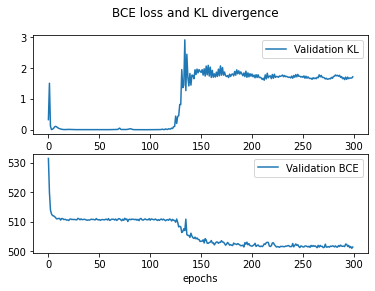

In [38]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('BCE loss and KL divergence')
ax1.plot(kl_list, label='Validation KL')
ax1.legend()
ax2.plot(bce_list, label='Validation BCE')
ax2.set(xlabel='epochs')
ax2.legend()
plt.show()

### Augmentation and Evaluation 

In [39]:
n = num_classes * 150

with torch.no_grad():
    z = torch.randn(n, 2).to(device)
    c = torch.randint(0, num_classes, (n,1)).to(dtype=torch.long)
    c_onehot = one_hot(c, num_classes).to(device)

    samples = vae.decode(z, c_onehot)

In [40]:
samples = samples*255

aug_images = samples.view(n, in_channels, 28, 28).to("cpu").numpy()
if in_channels == 1:
  aug_images = aug_images.squeeze(1)
if in_channels == 3:
  aug_images = aug_images.transpose(0,2,3,1)

aug_labels = c.to("cpu").numpy()

In [41]:
vae_aug_train_images = np.concatenate((train_images, aug_images))
vae_aug_train_labels = np.concatenate((train_labels, aug_labels))

vae_aug_train_data = MyDataset(vae_aug_train_images, vae_aug_train_labels, transform=transform)
vae_aug_train_loader = DataLoader(vae_aug_train_data, batch_size=batch_size, shuffle=True)

In [42]:
end_epoch = 100
val_auc_list = []; val_acc_list = []; state_list = []
dir_path = '/content/drive/MyDrive/'

for epoch in trange(start_epoch, end_epoch):
  train(model, optimizer, criterion, vae_aug_train_loader, device, task)
  val(model, val_loader, device, val_auc_list, val_acc_list, state_list, task, dir_path, epoch)

acc_list = np.array(val_acc_list)
index = acc_list.argmax()

path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, acc_list[index]))
torch.save(state_list[index], path)

print('epoch %s is the best model' % (index))

  1%|          | 1/100 [00:00<00:56,  1.74it/s]

Validation AUC: 1.00000 ACC: 0.84848


 11%|█         | 11/100 [00:05<00:43,  2.03it/s]

Validation AUC: 0.99565 ACC: 0.96970


 21%|██        | 21/100 [00:10<00:38,  2.03it/s]

Validation AUC: 0.99565 ACC: 0.96970


 31%|███       | 31/100 [00:15<00:34,  2.01it/s]

Validation AUC: 0.99565 ACC: 0.96970


 41%|████      | 41/100 [00:20<00:29,  2.00it/s]

Validation AUC: 0.99565 ACC: 0.96970


 51%|█████     | 51/100 [00:25<00:24,  1.97it/s]

Validation AUC: 0.99565 ACC: 0.96970


 61%|██████    | 61/100 [00:30<00:19,  1.97it/s]

Validation AUC: 0.99565 ACC: 0.96970


 71%|███████   | 71/100 [00:35<00:14,  1.95it/s]

Validation AUC: 0.99565 ACC: 0.96970


 81%|████████  | 81/100 [00:40<00:09,  1.93it/s]

Validation AUC: 0.99565 ACC: 0.96970


 91%|█████████ | 91/100 [00:45<00:04,  1.91it/s]

Validation AUC: 0.99565 ACC: 0.96970


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]

epoch 1 is the best model


In [43]:
restore_model_path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, acc_list[index]))
model.load_state_dict(torch.load(restore_model_path)['net'])
test(model, test_loader, device, task)

Test AUC: 0.90908 ACC: 0.79808


### Visualization

In [44]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    c = torch.randint(0, num_classes, (64,1)).to(dtype=torch.long)
    c_onehot = one_hot(c, num_classes).to(device)

    samples = vae.decode(z, c_onehot)

samples = samples.view(64,in_channels, 28, 28)
img_list=[]
img_list.append(vutils.make_grid(samples.cpu(), padding=2, normalize=True))

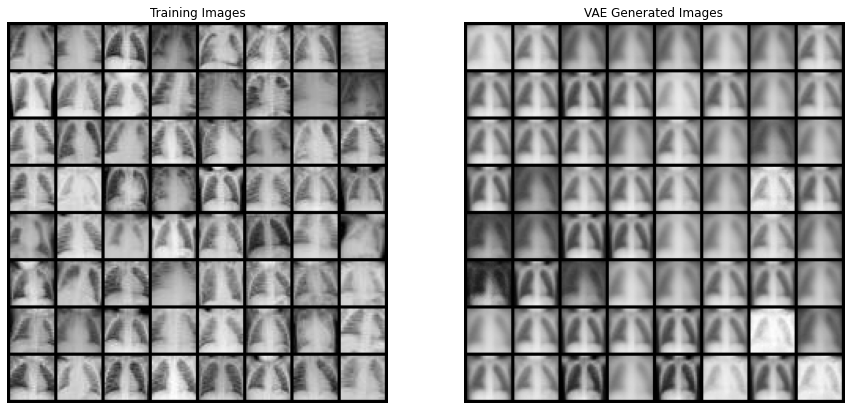

In [45]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the generated images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("VAE Generated Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Augmentation using GANs

### cGAN Model

The GAN framework establishes a min-max adversarial game between two neural networks: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a point $x$ in data space is a sample from the data distribution that we are trying to model, rather than a sample from our generative model $G$. 

Once again, for the task of data augmentation, we direct our choice towards a conditional version of a GAN. In the cGAN framework, the discriminator’s evaluation is done not only on the similarity between fake data and original data but also on the correspondence of the fake data image to its input label. 

We implement a simple version of a cGAN with `3` hidden fully connected layers for both the generator and the discriminator. The model is trained for `1000` epochs, using an `Adam optimizer` with a batch size of `128` and an initial learning rate of `1e−4`.

In [46]:
class Generator(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(Generator, self).__init__()

        self.in_channels = in_channels
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(self.n_classes, self.n_classes)

        self.model = nn.Sequential(
            nn.Linear(100 + n_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        img = self.model(x)
        return img.view(x.size(0), *(self.in_channels, 28, 28))

In [47]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(Discriminator, self).__init__()

        self.in_channels = in_channels
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + in_channels*784 , 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), self.in_channels * 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        validity = self.model(x)
        return validity

In [48]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.01)

### Training

In [49]:
discriminator = Discriminator(in_channels, num_classes).to(device)
generator = Generator(in_channels, num_classes).to(device)

discriminator.apply(weights_init)
generator.apply(weights_init)

gan_loss = nn.BCELoss()

optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.6, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.6, 0.999))

In [50]:
start_epoch = 0
end_epoch = 1000

G_losses = []
D_losses = []

for epoch in trange(start_epoch, end_epoch):
    G_loss_list = []
    D_loss_list = []

    for i, (img, label) in enumerate(train_loader):
        
        batch_size = img.shape[0]
        label = label.flatten()
        
        # Adversarial ground truths
        valid = torch.ones(batch_size).to(device)
        fake = torch.zeros(batch_size).to(device)

        # TRAIN GENERATOR
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, 100).to(device)  #Generated noise,100: latent space dim
        c = torch.randint(0, num_classes, (batch_size,)).to(device) #Generated labels

        generated_data = generator(z, c) 

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(generated_data, c).view(-1)
        G_loss = gan_loss(validity, valid)
        G_loss.backward()
        optimizer_G.step()
        
        G_loss_list.append(G_loss.item())

        
        # TRAIN DISCRIMINATOR 
        optimizer_D.zero_grad()

        validity_real = discriminator(img.to(device), label.to(device)).view(-1)
        d_real_loss = gan_loss(validity_real, valid)

        # Loss for fake images 
        validity_fake = discriminator(generated_data.detach(), c).view(-1)
        d_fake_loss = gan_loss(validity_fake, fake)

        # Loss measure for the discriminator
        D_loss = (d_fake_loss + d_real_loss) / 2
        D_loss.backward()
        optimizer_D.step()
        
        D_loss_list.append(D_loss.item())

    D_losses.append(np.mean(D_loss_list))
    G_losses.append(np.mean(G_loss_list))

    if epoch % 100 == 0:
      print('[%d/%d]: loss Discriminator: %.3f, loss Generator: %.3f' % (
            (epoch), end_epoch, np.mean(D_loss_list), np.mean(G_loss_list)))

  0%|          | 3/1000 [00:00<01:32, 10.83it/s]

[0/1000]: loss Discriminator: 0.692, loss Generator: 0.709


 10%|█         | 103/1000 [00:07<01:05, 13.64it/s]

[100/1000]: loss Discriminator: 0.660, loss Generator: 0.592


 20%|██        | 203/1000 [00:14<00:58, 13.66it/s]

[200/1000]: loss Discriminator: 0.673, loss Generator: 0.744


 30%|███       | 303/1000 [00:22<00:52, 13.35it/s]

[300/1000]: loss Discriminator: 0.672, loss Generator: 0.814


 40%|████      | 403/1000 [00:29<00:43, 13.84it/s]

[400/1000]: loss Discriminator: 0.645, loss Generator: 0.877


 50%|█████     | 503/1000 [00:36<00:35, 13.81it/s]

[500/1000]: loss Discriminator: 0.646, loss Generator: 1.011


 60%|██████    | 603/1000 [00:44<00:28, 13.82it/s]

[600/1000]: loss Discriminator: 0.615, loss Generator: 1.059


 70%|███████   | 703/1000 [00:51<00:21, 13.74it/s]

[700/1000]: loss Discriminator: 0.581, loss Generator: 0.964


 80%|████████  | 803/1000 [00:58<00:14, 13.16it/s]

[800/1000]: loss Discriminator: 0.660, loss Generator: 0.854


 90%|█████████ | 903/1000 [01:06<00:07, 13.58it/s]

[900/1000]: loss Discriminator: 0.622, loss Generator: 1.047


100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


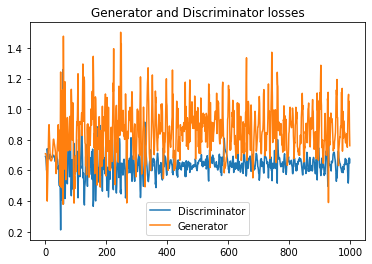

In [51]:
plt.plot(D_losses, label="Discriminator")
plt.plot(G_losses, label="Generator")
plt.title("Generator and Discriminator losses")
plt.xlabel='epochs'
plt.legend()
plt.show()

### Augmentation and Evaluation

In [52]:
n = num_classes * 150

with torch.no_grad():
    z = torch.randn(n, 100).to(device)
    c = torch.randint(0, num_classes, (n,)).to(device)
    
    samples = generator(z, c)

In [53]:
samples = samples * 255

aug_images = samples.view(n, in_channels, 28, 28).to("cpu").numpy()
if in_channels == 1:
  aug_images = aug_images.squeeze(1)
if in_channels == 3:
  aug_images = aug_images.transpose(0,2,4,1)

aug_labels = c.to("cpu").numpy()

In [54]:
gan_aug_train_images = np.concatenate((train_images, aug_images))
gan_aug_train_labels = np.concatenate((train_labels.flatten(), aug_labels))

gan_aug_train_data = MyDataset(gan_aug_train_images, gan_aug_train_labels, transform=transform)
gan_aug_train_loader = DataLoader(gan_aug_train_data, batch_size=batch_size, shuffle=True)

In [55]:
end_epoch=100

val_auc_list = []; val_acc_list = []; state_list = []
dir_path = '/content/drive/MyDrive/'

for epoch in trange(start_epoch, end_epoch):
  train(model, optimizer, criterion, gan_aug_train_loader, device, task)
  val(model, val_loader, device, val_auc_list, val_acc_list, state_list, task, dir_path, epoch)

acc_list = np.array(val_acc_list)
index = acc_list.argmax()

path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, acc_list[index]))
torch.save(state_list[index], path)

print('epoch %s is the best model' % (index))

  1%|          | 1/100 [00:00<01:09,  1.43it/s]

Validation AUC: 1.00000 ACC: 0.84848


 11%|█         | 11/100 [00:07<00:55,  1.59it/s]

Validation AUC: 0.98261 ACC: 0.93939


 21%|██        | 21/100 [00:13<00:49,  1.59it/s]

Validation AUC: 0.97826 ACC: 0.93939


 31%|███       | 31/100 [00:19<00:43,  1.57it/s]

Validation AUC: 0.98261 ACC: 0.93939


 41%|████      | 41/100 [00:26<00:37,  1.57it/s]

Validation AUC: 0.97391 ACC: 0.93939


 51%|█████     | 51/100 [00:32<00:31,  1.57it/s]

Validation AUC: 0.97391 ACC: 0.93939


 61%|██████    | 61/100 [00:38<00:24,  1.58it/s]

Validation AUC: 0.97391 ACC: 0.93939


 71%|███████   | 71/100 [00:44<00:18,  1.59it/s]

Validation AUC: 0.97391 ACC: 0.93939


 81%|████████  | 81/100 [00:51<00:11,  1.60it/s]

Validation AUC: 0.97391 ACC: 0.93939


 91%|█████████ | 91/100 [00:57<00:05,  1.61it/s]

Validation AUC: 0.97391 ACC: 0.93939


100%|██████████| 100/100 [01:03<00:00,  1.59it/s]

epoch 9 is the best model


In [56]:
restore_model_path = os.path.join(dir_path, 'ckpt_%d_auc_%.5f.pth' % (index, acc_list[index]))
model.load_state_dict(torch.load(restore_model_path)['net'])
test(model, test_loader, device, task)

Test AUC: 0.90250 ACC: 0.79808


### Visualization

In [58]:
with torch.no_grad():
    z = torch.randn(64, 100).to(device)
    c = torch.randint(0, num_classes, (64,)).to(device)
    
    samples = generator(z, c)

samples = samples.view(64,in_channels, 28, 28)
img_list=[]
img_list.append(vutils.make_grid(samples.cpu(), padding=2, normalize=True))

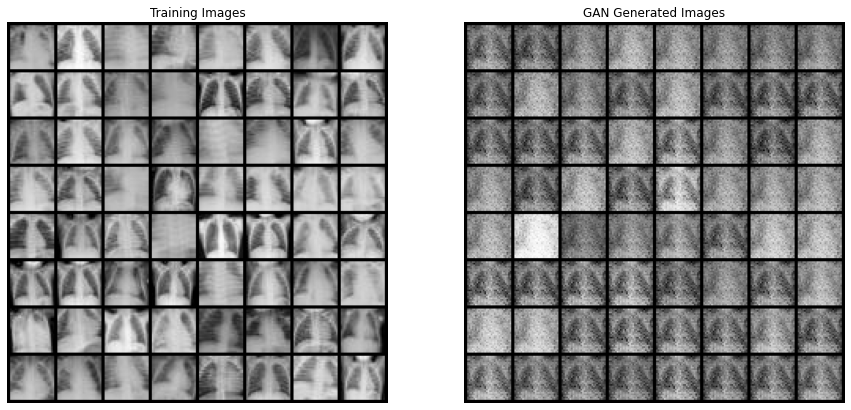

In [59]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Plot the generated images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("GAN Generated Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()